### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 3

**Student Name:**    Xing Yang Goh

**Student ID:**     1001969

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [242]:
# Import Packages
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random
from scipy.linalg import null_space

In [243]:
def coordinate_transformation(kp1, kp2):
    u_bar = 1/n*

### 1. Load images and compute correspondences


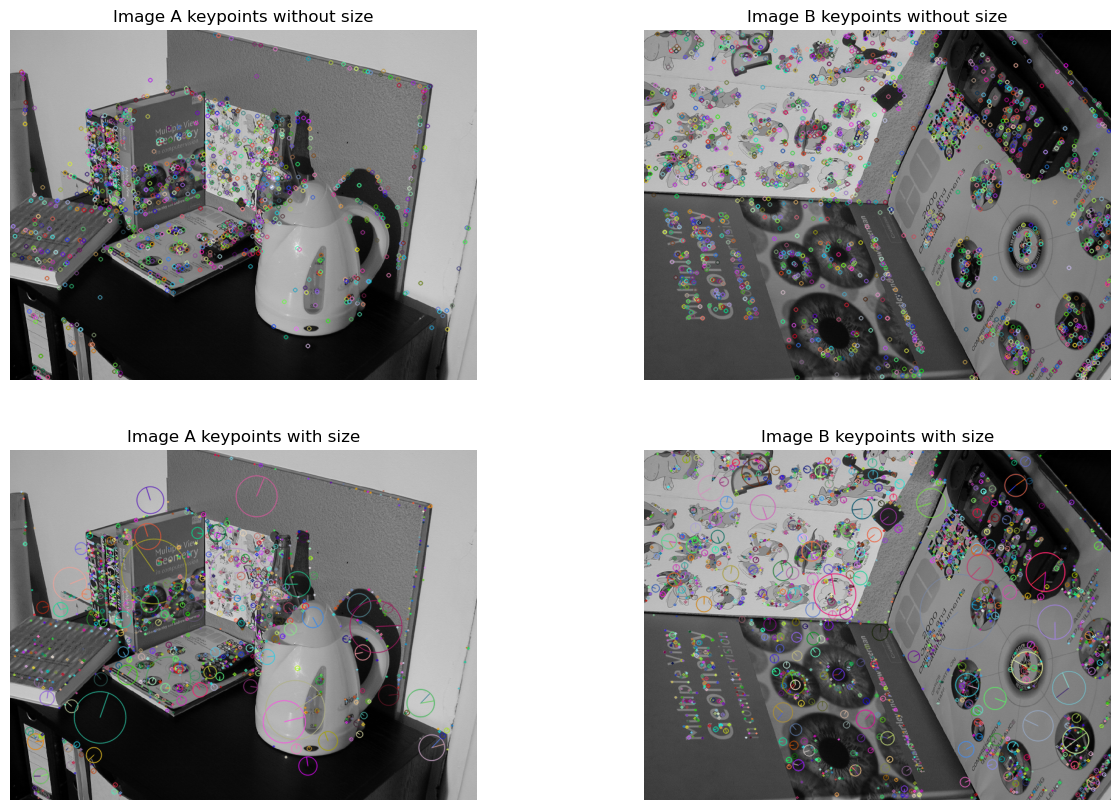

Number of keypoints detected in the Image A:  1265
Number of keypoints detected in the Image B:  2183


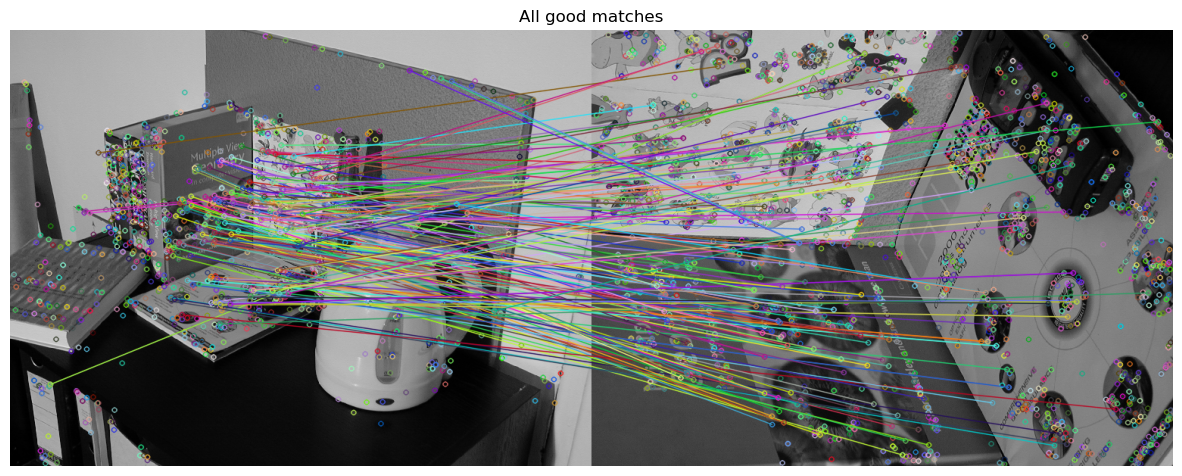


Number of good matches between two images:  163


In [502]:
# Read in images from a filepath as graycsale.
rootpath='./kusvod2'
imgA = cv2.imread(os.path.join(rootpath, 'bookshA.png'),cv2.IMREAD_GRAYSCALE)
imgB = cv2.imread(os.path.join(rootpath, 'bookshB.png'),cv2.IMREAD_GRAYSCALE)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imgA,None)
kp2, des2 = sift.detectAndCompute(imgB,None)

# Draws the small circles on the locations of keypoints without size
kp1_without_size = cv2.drawKeypoints(imgA,kp1,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )
kp2_without_size = cv2.drawKeypoints(imgB,kp2,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(imgA,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(imgB,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images with&without the size of keypoints 
plt.subplots(figsize=(15, 10)) 

plt.subplot(2,2,1)
plt.imshow(kp1_without_size, cmap='gray')  
plt.title('Image A keypoints without size')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(kp2_without_size, cmap='gray')  
plt.title('Image B keypoints without size')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Image A keypoints with size')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Image B keypoints with size')
plt.axis('off')

plt.show() 

# Print the number of keypoints detected
print("Number of keypoints detected in the Image A: ", len(kp1))
print("Number of keypoints detected in the Image B: ", len(kp2))

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Create a mask to draw all good matches
matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
pts1 = []
pts2 = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(imgA,kp1,imgB,kp2,matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# Print total number of good matches between two images
print("\nNumber of good matches between two images: ", len(good))



### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [570]:
# Calculate transformation for scaling and shifting
p1_all = []
p2_all = []
q1_all = []
q2_all = []
match_num = len(good)
for i in range(match_num):
    p1, p2 = kp1[good[i].queryIdx].pt
    q1, q2 = kp2[good[i].trainIdx].pt
    p1_all.append(p1)
    p2_all.append(p2)
    q1_all.append(q1)
    q2_all.append(q2)

p1_bar = 1/match_num * np.sum(p1_all)
p2_bar = 1/match_num * np.sum(p2_all)
q1_bar = 1/match_num * np.sum(q1_all)
q2_bar = 1/match_num * np.sum(q2_all)

p1_tilde = p1_all - p1_bar
p2_tilde = p2_all - p2_bar
q1_tilde = q1_all - q1_bar
q2_tilde = q2_all - q2_bar

s_p = np.sqrt(2)/np.sqrt((1/match_num * np.sum(p1_tilde*p1_tilde + p2_tilde*p2_tilde)))
s_q = np.sqrt(2)/np.sqrt((1/match_num * np.sum(q1_tilde*q1_tilde + q2_tilde*q2_tilde)))


T_p = np.diag([1,1,1])
T_p[0][2] = -p1_bar
T_p[1][2] = -p2_bar
T_p = np.dot(np.diag([s_p,s_p,1]),T_p)

T_q = np.diag([1,1,1])
T_q[0][2] = -q1_bar
T_q[1][2] = -q2_bar
T_q = np.dot(np.diag([s_q,s_q,1]),T_q)

# Randomly select 8 unique matching points 
required_points = 8
assert len(good) >= required_points
match_indices = []
for i in range(required_points):
    random_point = random.randint(0,len(good)-1)
    while random_point in match_indices:
        random_point = random.randint(0,len(good)-1)
    match_indices.append(random_point) 


# Constructing matrix
mat = [[0 for _ in range(required_points+1)] for _ in range(required_points)]

# Use points to generate the matrix, i=row j=column
for i in range(required_points):
    p1, p2 = kp1[good[match_indices[i]].queryIdx].pt
    p_hat = T_p*np.array([p1,p2,1])
    p1 = p_hat[0][0]
    p2 = p_hat[1][1]
    q1, q2 = kp2[good[match_indices[i]].trainIdx].pt
    q_hat = T_q*np.array([q1,q2,1])
    q1 = q_hat[0][0]
    q2 = q_hat[1][1]
    #q1, q2 = normalise_coordinates(q1, q2, imgB)
    mat[i][0] = p1*q1
    mat[i][1] = p2*q1
    mat[i][2] = q1
    mat[i][3] = p1*q2
    mat[i][4] = p2*q2
    mat[i][5] = q2
    mat[i][6] = p1
    mat[i][7] = p2
    mat[i][8] = 1

# Using SVD to compute the null space to find the draft F matrix
rank = np.linalg.matrix_rank(mat)
assert rank == required_points
U, s, V = np.linalg.svd(mat, full_matrices = True)
rank = np.linalg.matrix_rank(mat)
U, s, V = np.linalg.svd(mat, full_matrices = True)
t_V_mat = np.transpose(V)
ncols = t_V_mat.shape[1]
right_null_mat = t_V_mat[:,rank:ncols]

# Converting nullspace vector to draft 3x3 F matrix
F_dim = 3
F_draft = [[0 for _ in range(F_dim)] for _ in range(F_dim)]
F_draft[0][0] = float(right_null_mat[0])
F_draft[0][1] = float(right_null_mat[1])
F_draft[0][2] = float(right_null_mat[2])
F_draft[1][0] = float(right_null_mat[3])
F_draft[1][1] = float(right_null_mat[4])
F_draft[1][2] = float(right_null_mat[5])
F_draft[2][0] = float(right_null_mat[6])
F_draft[2][1] = float(right_null_mat[7])
F_draft[2][2] = float(right_null_mat[8])

# Perform another SVD of the draft F matrix and zero smallest eigenvalue to form F matrix
U, s, V = np.linalg.svd(F_draft, full_matrices = True)
s[np.argmin(s)]=0
F_norm = np.dot(np.dot(U,np.diag(s)),V)
F = np.dot(np.dot(np.transpose(T_q),F_norm),T_p)
print(np.linalg.det(F))
# Check performance of the F matrix using remaining correspondence points
test_matches = np.delete(good, match_indices)
epsilon = 1e-15
inlier_count = 0
for matches in test_matches:
    p1, p2 = kp1[matches.queryIdx].pt
    q1, q2 = kp2[matches.trainIdx].pt
    if np.dot(np.dot(np.array([q1,q2,1]),F),np.array([p1,p2,1])) < epsilon:
        inlier_count = inlier_count+1
print(inlier_count)
F

-8.407670342430399e-26
65


array([[ 1.43682805e-05, -2.69465792e-06, -9.10525720e-03],
       [-6.65001928e-08,  1.85481335e-05, -7.41360522e-03],
       [-4.69533652e-03, -5.86580374e-03,  5.68910915e+00]])

In [561]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
epsilon = 1e-15
inlier_count = 0
for matches in test_matches:
    p1, p2 = kp1[matches.queryIdx].pt
    q1, q2 = kp2[matches.trainIdx].pt
    if np.dot(np.dot(np.array([q1,q2,1]),F),np.array([p1,p2,1])) < epsilon:
        inlier_count = inlier_count+1
print(inlier_count)
F

74


array([[ 5.56473185e-06,  6.67720382e-09, -8.58569031e-04],
       [ 4.43204445e-08,  5.51507085e-06, -1.16051881e-03],
       [-1.12500429e-03, -3.95196889e-03,  1.00000000e+00]])

### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [553]:
q_hat = T_q*np.array([q1,q2,1])
q_hat[0][0]

4.076178412887641